## Benchmark 4: oneshot naive model cross validation
Major consideration here is, do we score one time point from the forecast period or all four? Thinking we should probably do both. Scoring one point will give us the best comparison to the current public leaderboard. But the actual model we need to build will be predicting four future timepoints.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Cross validation SMAPE](#cross_validation_smape)

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf

import numpy as np
import pandas as pd

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3


<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model

In [2]:
model_order = 4
forecast_horizon = 4

<a name="load_inspect"></a>
### 2. Load & inspect

In [3]:
# Load cross validation data
input_file = f'{conf.PARSED_DATA_PATH}/order{model_order}_horizon{forecast_horizon}.npy'
parsed_data = np.load(input_file)

print(f'Shape: {parsed_data.shape}')

Shape: (100320, 2, 4, 4)


OK this, numpy array is structured as follows:
+ **First dimension**: data elements
+ **Second dimension**: input, forecast block halves
+ **Third dimension**: rows
+ **Fourth dimension**: columns: *cfips, first_day_of_month, microbusiness_density, active*

Let's start by defining some helper functions so that we can easily loop over multiple samples, calculating training and validation scores for each.

<a name="cross_validation_SMAPE"></a>
### 3. Cross validation SMAPE

In [4]:
def sample_parsed_data(
    parsed_data,
    training_fraction      
):
    '''Randomly select 30% of the data for validation, keep the rest for training'''

    # Calculate sample sizes
    training_sample_size = int(len(parsed_data) * training_fraction)

    # Generate list of random indices for training sample
    random_training_indices = np.random.choice(parsed_data.shape[0], training_sample_size, replace=False)

    # Use random indices to extract training sample from parsed data
    training_sample = parsed_data[random_training_indices]

    # Loop on parsed_data indices, if index was not in random validation sample
    # add that data to the validation sample
    validation_sample = []

    for i in range(len(parsed_data)):
        if i not in random_training_indices:
            validation_sample.append(parsed_data[i])

    # Convert to numpy array
    validation_sample = np.array(validation_sample)

    return training_sample, validation_sample

In [5]:
def two_point_smape(actual, forecast):

    if actual == 0 and forecast == 0:
        return 0

    smape = abs(forecast - actual) / ((abs(actual) + abs(forecast)) / 2)
    
    return smape

In [6]:
def naive_model_smape_score(sample):
    one_point_smape_values = []
    four_point_smape_values = []

    for block in sample:

        # Get the last microbusiness_density value from the input block
        # and use this as our constant forecast
        forecast_value = block[0,-1,2]

        # Get the target values
        actual_values = block[1,0:,2]

        # print()
        # print(f'Input: {block[0,0:,2]}')
        # print(f'Target: {actual_values}')
        # print(f'Forecast: {[forecast_value] * len(actual_values)}')

        # Score the predictions
        smape_values = []

        for actual_value in actual_values:
            smape_values.append(two_point_smape(actual_value, forecast_value))

        one_point_smape_values.append(smape_values[0])
        four_point_smape_values.extend(smape_values)

    #     print(f'SMAPE values: {smape_values}')

    # print()
    # print(f'Sample one point SMAPE values: {len(one_point_smape_values)}')
    # print(f'Sample four point SMAPE values: {len(four_point_smape_values)} ')

    one_point_smape_score = (100/len(one_point_smape_values)) * sum(one_point_smape_values)
    four_point_smape_score = (100/len(four_point_smape_values)) * sum(four_point_smape_values)

    return one_point_smape_score, four_point_smape_score

In [7]:
smape_scores = {
    'one_point_training': [],
    'one_point_validation': [],
    'four_point_training': [],
    'four_point_validation': []
}

for i in range(100):

    training_sample, validation_sample = sample_parsed_data(
        parsed_data,
        0.7    
    )

    one_point_training_smape, four_point_training_smape = naive_model_smape_score(training_sample)
    one_point_validation_smape, four_point_validation_smape = naive_model_smape_score(validation_sample)

    smape_scores['one_point_training'].append(one_point_training_smape)
    smape_scores['one_point_validation'].append(one_point_validation_smape)
    smape_scores['four_point_training'].append(four_point_training_smape)
    smape_scores['four_point_validation'].append(four_point_validation_smape)

    print(f'Fold {i} SMAPE scores:')
    print(f'\tOne point training: {one_point_training_smape}')
    print(f'\tOne point validation: {one_point_validation_smape}')
    print(f'\tFour point training: {four_point_training_smape}')
    print(f'\tFour point validation: {four_point_validation_smape}')
    print()

Fold 0 SMAPE scores:
	One point training: 1.778815828936121
	One point validation: 1.7632539994202294
	Four point training: 3.0911940909381777
	Four point validation: 3.067247105085746

Fold 1 SMAPE scores:
	One point training: 1.783958967090859
	One point validation: 1.7512533437258204
	Four point training: 3.0917671995536753
	Four point validation: 3.0659098516496512

Fold 2 SMAPE scores:
	One point training: 1.782812374163358
	One point validation: 1.7539287272233766
	Four point training: 3.0946743994094983
	Four point validation: 3.0591263853195994

Fold 3 SMAPE scores:
	One point training: 1.7691170357829185
	One point validation: 1.7858845167777482
	Four point training: 3.069113892459744
	Four point validation: 3.1187675682020823

Fold 4 SMAPE scores:
	One point training: 1.7817715891767019
	One point validation: 1.7563572255254922
	Four point training: 3.091051869340957
	Four point validation: 3.0675789554792923

Fold 5 SMAPE scores:
	One point training: 1.7740936606025628
	One 

<a name="results"></a>
### 4. Results

In [8]:
smape_scores_df = pd.DataFrame(smape_scores)
smape_scores_df.head()

,one_point_training,one_point_validation,four_point_training,four_point_validation
0,1.778816,1.763254,3.091194,3.067247
1,1.783959,1.751253,3.091767,3.065910
2,1.782812,1.753929,3.094674,3.059126
3,1.769117,1.785885,3.069114,3.118768
4,1.781772,1.756357,3.091052,3.067579


In [9]:
smape_scores_df.describe()

,one_point_training,one_point_validation,four_point_training,four_point_validation
count,100.000000,100.000000,100.000000,100.000000
mean,1.774673,1.772921,3.084932,3.081859
std,0.009895,0.023088,0.011275,0.026308
min,1.750185,1.720038,3.062291,3.003852
25%,1.767916,1.756189,3.077344,3.065342
50%,1.774343,1.773691,3.083842,3.084402
75%,1.781844,1.788688,3.092011,3.099564
max,1.797337,1.830060,3.118364,3.134687


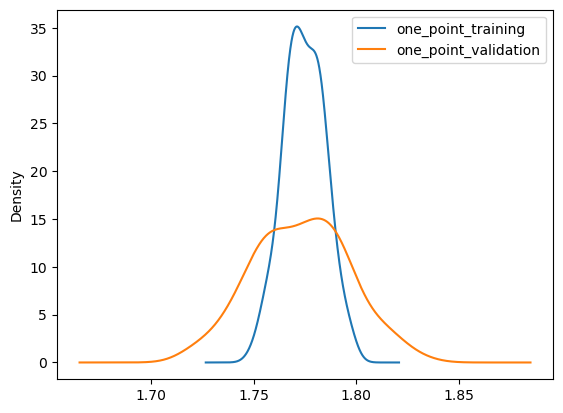

In [10]:
one_point_smape_scores_df = smape_scores_df[['one_point_training', 'one_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

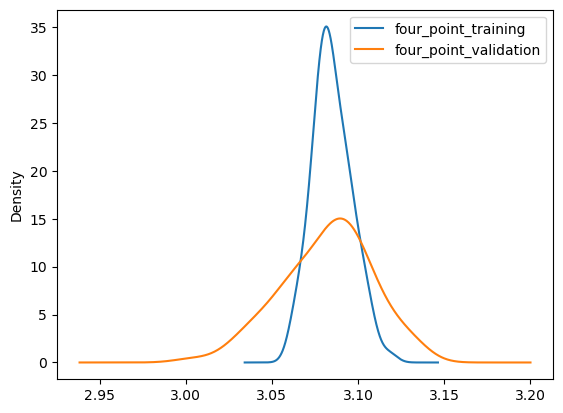

In [11]:
one_point_smape_scores_df = smape_scores_df[['four_point_training', 'four_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

OK - so cross validation SMAPE scores are quite a bit higher than the public leaderboard score using the same 'model'. I also notice that the four point SMAPE is much larger than the one point SMAPE. Will have to come back and look at this with fresh eyes to see if this is expected behavior or if there is a problem with my calculations. But it could just be that naive, 'carry-forward' predictions get worse the farther forward they are carried. 

Anyway that's the first pass at it complete.

**REVISIT** Double checked sampling and scoring logic. Looks good, ran 100 fold cross validation. One point SMAPE is still much worse than the actual public leaderboard score for this model. Maybe November is just a really lucky test sample for this model - i.e. not much changed that month. Come to think of it, we could calculate how likely a SMAPE equal to or better than that observed on the leaderboard is using the mean and standard deviation from our cross validation experiment.

In [12]:
from statistics import NormalDist

one_point_training_mean = smape_scores_df['one_point_training'].describe()['mean']
one_point_training_std = smape_scores_df['one_point_training'].describe()['std']

print(f'Mean: {one_point_training_mean}')
print(f'Standard deviation: {one_point_training_std}')

leaderboard_score_probability = NormalDist(mu=one_point_training_mean, sigma=one_point_training_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability}')

Mean: 1.7746730359829925
Standard deviation: 0.009894688037512707
Probability of SMAPE <= 1.0936: 0.0


Yikes - this is kind of bad news. It means that either we are doing something wrong in our sampling & SMAPE calculations and inflating our SMAPE values, or the current public leaderboard is being scored against a very 'weird' (and easy for the naive model) sample. Let's try one more thing and repeat this experiment with a small sample size. Reasoning here is on the public leaderboard each county gets scored once (~3,000 data points) whereas our training samples are around 70,000 points each. Seems more likely to get extreme values in small samples.

In [13]:
smape_scores = {
    'one_point_training': [],
    'one_point_validation': [],
    'four_point_training': [],
    'four_point_validation': []
}

for i in range(100):

    training_sample, validation_sample = sample_parsed_data(
        parsed_data,
        0.98675 # Note: calculated fraction that will give a 
                # validation set ~num counties by hand here
    )

    one_point_training_smape, four_point_training_smape = naive_model_smape_score(training_sample)
    one_point_validation_smape, four_point_validation_smape = naive_model_smape_score(validation_sample)

    smape_scores['one_point_training'].append(one_point_training_smape)
    smape_scores['one_point_validation'].append(one_point_validation_smape)
    smape_scores['four_point_training'].append(four_point_training_smape)
    smape_scores['four_point_validation'].append(four_point_validation_smape)

    print(f'Fold {i} SMAPE scores:')
    print(f'\tOne point training: {one_point_training_smape}')
    print(f'\tOne point validation: {one_point_validation_smape}')
    print(f'\tFour point training: {four_point_training_smape}')
    print(f'\tFour point validation: {four_point_validation_smape}')
    print()

Fold 0 SMAPE scores:
	One point training: 1.7760949202713625
	One point validation: 1.6291872030825914
	Four point training: 3.0878400482950963
	Four point validation: 2.7989446135053044

Fold 1 SMAPE scores:
	One point training: 1.774299163943587
	One point validation: 1.7628427811915928
	Four point training: 3.084547823674108
	Four point validation: 3.0439801888746367

Fold 2 SMAPE scores:
	One point training: 1.7750313186045574
	One point validation: 1.7083495557115775
	Four point training: 3.086875882700989
	Four point validation: 2.870706081297809

Fold 3 SMAPE scores:
	One point training: 1.7735925736688862
	One point validation: 1.8154332859240878
	Four point training: 3.0836991845276724
	Four point validation: 3.1071431882023903

Fold 4 SMAPE scores:
	One point training: 1.7767401160927452
	One point validation: 1.5811661998052016
	Four point training: 3.0872783774411094
	Four point validation: 2.840748972787174

Fold 5 SMAPE scores:
	One point training: 1.773082944515017
	One 

In [14]:
smape_scores_df = pd.DataFrame(smape_scores)
smape_scores_df.describe()

,one_point_training,one_point_validation,four_point_training,four_point_validation
count,100.000000,100.000000,100.000000,100.000000
mean,1.774156,1.773479,3.084045,3.081437
std,0.001900,0.141386,0.002333,0.173615
min,1.765293,1.521840,3.076453,2.773546
25%,1.773078,1.675232,3.082856,2.949418
50%,1.774250,1.766472,3.084147,3.073836
75%,1.775476,1.853728,3.085818,3.169911
max,1.777537,2.433178,3.088181,3.646495


In [15]:
one_point_validation_mean = smape_scores_df['one_point_validation'].describe()['mean']
one_point_validation_std = smape_scores_df['one_point_validation'].describe()['std']

print(f'Mean: {one_point_validation_mean}')
print(f'Standard deviation: {one_point_validation_std}')

leaderboard_score_probability = NormalDist(mu=one_point_validation_mean, sigma=one_point_validation_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability}')

Mean: 1.7734793782055123
Standard deviation: 0.1413861598458952
Probability of SMAPE <= 1.0936: 7.596891240524428e-07


It's still a vanishingly small probability of getting a sample from the training data on which the naive, 'carry-forward' model does as well or better on that it does on the current leaderboard test set. This makes things a bit difficult - i.e. we can't put much stock in our leaderboard score! Other methods might do better. But, I worry that if the leaderboard test set is so different from the rest of the dataset we will hurt our generalizable chasing a good public leaderboard score. If we tune everything to do as well as possible on that specific test set, we might get destroyed on the private leaderboard when new data shows up. Good news is, the public leaderboard test data for November data should be published soon.

<a name="TODO"></a>
### 5. TODO
1. Check cross validation parsing for frameshift/indexing errors.
2. Parallelize sampling over processors using python multiprocessing module.
2. Refactor helper functions into module.